In [1]:
#!pip install -U jupyter
#!pip install torch
#!pip install torchsummary
#!pip install torchvision
#!pip install tensorflow-gpu
#!pip install pycocotools
#!conda remove tensorflow-gpu
#!conda install pytorch torchvision cudatoolkit=10.2 -c pytorch
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.5/index.html
#!pip install opencv-python 

In [27]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())
device = torch.device("cuda") 


1.5.0+cu101 True


In [28]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import pickle
import random
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
import deepdish as dd
import pycocotools as pycoco
import warnings
import os
warnings.filterwarnings("ignore")

#### Some detectron2 utilities

In [29]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from skimage import measure
torch.cuda.empty_cache()

## Train on  a custom dataset (fine tuning)

first need to register a dataset in the coco formart  to work with predefined data loaders


In [30]:
def get_annos():
    with open('dorm_annotations_2.pickle', 'rb') as f:
        annotations = pickle.load(f)
        
    from sklearn.model_selection import train_test_split as tts
    train_annotations,test_annotations = tts(annotations,test_size = 0.3, random_state = 75, shuffle = True)
    data = {'train':train_annotations,'val':test_annotations}
    return data

def create_dataset(annotation):
    dataset_dicts = []
    image_path = os.getcwd().replace("src",'images') + '/'
    for im in range(len(annotation)):
        dict1 = {}
        
        dict1["file_name"] = image_path+annotation[im]["file_name"]
        height, width = cv2.imread(dict1["file_name"]).shape[:2]
        dict1["height"] = height
        dict1["width"] = width
        dict1["image_id"] = (im+1)
        
        objs = []
        for anno in annotation[im]['annotations']:
            #assert not anno["region_attributes"]
            try:
                cat =  int(anno['region_attributes']['region']=='opening')
                anno = anno["shape_attributes"]
                px = anno["all_points_x"]
                py = anno["all_points_y"]
                poly = [(x+0.5, y+0.5) for x,y in zip(px,py)]
                poly = [p for x in poly for p in x]

                obj = {
                    "bbox":[np.min(px), np.min(py), np.max(px), np.max(py)],
                    "bbox_mode":BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id":cat,
                    "iscrowd":0,
                    }
                objs.append(obj)
            except Exception as e:
                print("image  "+  dict1["file_name"] + ": ", e)
            
        dict1["annotations"] = objs
        
        dataset_dicts.append(dict1)
    return dataset_dicts


def register_dset():
    DatasetCatalog.clear()
    for d_set in data:
        DatasetCatalog.register("doornet_%s"%d_set, lambda d_set=d_set: create_dataset(data[d_set]))
        MetadataCatalog.get("doornet_%s"%d_set).set(thing_classes = ["door",'opening'])

### load annotations, Register dataset
data = get_annos()
register_dset()

----

### Now create a detectron config and defaultPredictor to run inference

In [31]:
cfg =get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 #model threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

### check dataset registration success, load visualize annotations ontop of image

image  /mnt/lts/nfs_fs02/sadow_lab/personal/moselim/door/dormalarm/images/pic (34).JPG:  'region'
image  /mnt/lts/nfs_fs02/sadow_lab/personal/moselim/door/dormalarm/images/pic (34).JPG:  'region'
image  /mnt/lts/nfs_fs02/sadow_lab/personal/moselim/door/dormalarm/images/pic (59).JPG:  'region'
image  /mnt/lts/nfs_fs02/sadow_lab/personal/moselim/door/dormalarm/images/pic (71).JPG:  'region'


<Figure size 432x288 with 0 Axes>

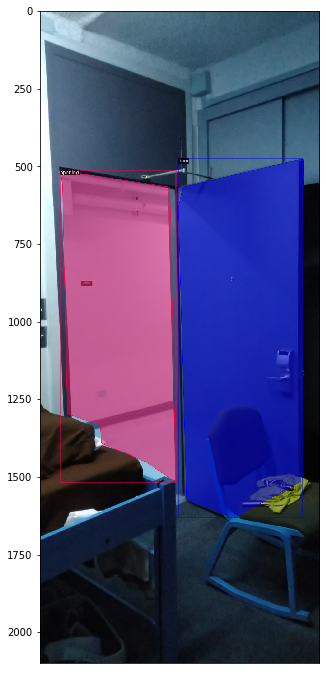

In [32]:
### Train test annotation split 
fish_metadata = MetadataCatalog.get("doornet_train")
dataset_dicts = create_dataset(data["train"])

plt.figure()

r = c = 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(17,12))
plt.xticks([])
plt.xticks([])
i=0
j=0
for d in random.sample(dataset_dicts,r*c):
    if i == r:
        i = 0
        j+=1
    img = cv2.imread(d['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata = fish_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    axarr.imshow(Image.fromarray(vis.get_image()[:,:,::-1]))
    i+=1
    
plt.show()

-----

## Train

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("doornet_train",)
cfg.DATASETS.TEST = () 
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 6000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

### Tensorboard

In [ ]:
%matplotlib inline 
%reload_ext tensorboard
%tensorboard --logdir output

## Inference 

image  /mnt/lts/nfs_fs02/sadow_lab/personal/moselim/door/dormalarm/images/pic (47).JPG:  'region'


<Figure size 432x288 with 0 Axes>

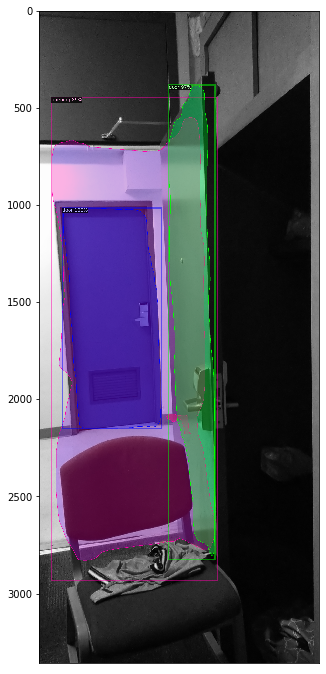

In [54]:
from detectron2.utils.visualizer import ColorMode

# load weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
# Set training data-set path
cfg.DATASETS.TEST = ("doornet_val", )
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

plt.figure()

r = 1
c = 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(20,12))
plt.xticks([])
plt.xticks([])
i=0
j=0

dataset_dicts = create_dataset(data["val"])
for d in random.sample(dataset_dicts, r*c):
    if i == r:
        i = 0
        j+=1
        
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axarr.imshow(Image.fromarray(v.get_image()[:, :, ::-1]))
    i+=1
plt.show()

In [91]:
print(outputs["instances"].to("cpu").pred_classes)
all(outputs["instances"].to("cpu").pred_classes == 1)


tensor([0, 0, 1])


False

### Evaluation on the validation set

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator  =  COCOEvaluator("doornet_val", cfg, False, output_dir="./output/")
val_loader =  build_detection_test_loader(cfg, "doornet_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

-----

# run video visualizer

In [66]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy
import tqdm
import cv2
import pyaudio
import wave
import threading
import time
import subprocess

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.structures import BoxMode
from skimage import measure
from mail import Email_pypy
torch.cuda.empty_cache()

In [96]:
#### init video
video = cv2.VideoCapture('dom_test1.mp4')
#video = cv2.VideoCapture(0)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

video_writer = cv2.VideoWriter("out.mp4",
                               fourcc = cv2.VideoWriter_fourcc(*"mp4v"),
                               fps = frames_per_second,
                               frameSize = (width,height),
                               isColor = True)

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TRAIN = ("doornet_train",)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75
predictor = DefaultPredictor(cfg)

v  = VideoVisualizer(MetadataCatalog.get("doornet_train"), ColorMode.IMAGE)

In [97]:
def show_webcam(video, maxFrames, mirror=False):
    readFrames = 0
    closed = False
    switch = False
    swinumy = 0
    message = ""
    while True:
        ret_val, img = video.read()
        
        if not ret_val:
            break
            
        if mirror: 
            img = cv2.flip(img, 1)
            
        outputs = predictor(img)
        
        if closed and any(outputs["instances"].to("cpu").pred_classes == 1):
            swinumy+=1
            cv2.imwrite("intruder_open_%s.png"%swinumy, img)
            message = " Door Open, image number: %s"%swinumy
            switch =  True
            closed = False
        elif closed == False and all(outputs["instances"].to("cpu").pred_classes == 0):
            swinumy+=1
            cv2.imwrite("intruder_closed_%s.png"%swinumy, img)
            message = "Door Closed, image number: %s"%swinumy
            switch =  True
            closed = True
        else:
            switch =  False
        
        if switch:
            Email_pypy(message)
            
            
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        visualization  = v.draw_instance_predictions(img, outputs["instances"].to("cpu"))
        
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)
        
        yield visualization
        
        readFrames -= -1
        if readFrames > maxFrames or (cv2.waitKey(10) & 0xff == ord('q')):
            print("CAMERA CLOSING")
            break
            

In [98]:
print("PRESS ESC TO QUIT")
num_frames = 1000
from tqdm import tqdm
for visualization in tqdm(show_webcam(video, num_frames, mirror=True), total = num_frames):
    cv2.imwrite("POSE  detectron2.png", visualization)
    video_writer.write(visualization)

video.release()
video_writer.release()
cv2.destroyAllWindows()

  0%|          | 0/1000 [00:00<?, ?it/s]

PRESS ESC TO QUIT


1001it [04:16,  3.91it/s]                          

CAMERA CLOSING


In [53]:
import os
duration = 3000
freq = 440
os.system('play -nq -t alsa synth {} sine {}'.format(duration,freq))

32512